<a href="https://colab.research.google.com/github/DEYIF/IMG-DLBreast/blob/main/EvaluationFrame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Google Drive Files

In [2]:
# import drive files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Set Google Colab

In [3]:
using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything-2.git'

PyTorch version: 2.5.1+cu121
Torchvision version: 0.20.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything-2.git to /tmp/pip-req-build-d7k2_1ad
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything-2.git /tmp/pip-req-build-d7k2_1ad
  Resolved https://github.com/facebookresearch/segment-anything-2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
  Created wh

Set folder path

In [11]:
# image_folder = '/content/drive/MyDrive/trabalho/SAM2/BUS_all_dataset_resize/test/images'  # path of all the test images
# gt_folder = '/content/drive/MyDrive/trabalho/SAM2/BUS_all_dataset_resize/test/labels'  # path of ground truth masks
# result_folder = '/content/drive/MyDrive/trabalho/SAM2/BUS_all_dataset_resize/test/results' # path of evaluation result images
# sam2_checkpoint = "/content/drive/MyDrive/sam2_hiera_large.pt"  #checkpoints (coefficients) of the SAM2 model
image_folder = '/content/drive/MyDrive/DLBreast/SAM2/BUS_all_dataset_resize/test/images'
gt_folder = '/content/drive/MyDrive/DLBreast/SAM2/BUS_all_dataset_resize/test/labels'
result_folder = '/content/drive/MyDrive/DLBreast/SAM2/BUS_all_dataset_resize/test/results'
sam2_checkpoint = "/content/drive/MyDrive/DLBreast/SAM2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

## Import Moudles & Define Functions

In [17]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
    current_device = torch.cuda.current_device()
    print("Current GPU device:", torch.cuda.get_device_name(current_device))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

#Define functions
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)
    ax.imshow(img)

def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

def threshold_mask(probability_mask, threshold=0.5):
    return (probability_mask >= threshold).astype(int)

def dice_coefficient(pred_mask, true_mask):
    intersection = np.sum(pred_mask * true_mask)
    return (2. * intersection) / (np.sum(pred_mask) + np.sum(true_mask))

def calculate_iou(binary_mask1, binary_mask2):
    intersection = np.logical_and(binary_mask1, binary_mask2).sum()
    union = np.logical_or(binary_mask1, binary_mask2).sum()
    return 1.0 if union == 0 else intersection / union



def find_median_point(gt):
    """
    find the median point of all white (front mask) points

    gt: ground truth binary mask

    return:
    median_x, median_y: the coordinates of the median point
    """
    # find all white (front mask) points
    white_pixels = np.column_stack(np.where(gt == 1))

    if len(white_pixels) > 0:
        median_x = np.median(white_pixels[:, 0]).astype(int)
        median_y = np.median(white_pixels[:, 1]).astype(int)

        # validaton
        assert gt[median_x, median_y] == 1, "Median point not in white region"

        return median_x, median_y
    else:
        raise ValueError("No white pixels found in the mask")

def find_rect_box(gt):
    # find all white pixels
    white_pixels = np.column_stack(np.where(gt == 1))
    # find the boundary
    if len(white_pixels) > 0:
        x_min, y_min = np.min(white_pixels, axis=0)
        x_max, y_max = np.max(white_pixels, axis=0)
    else:
        print("invalid mask")
    input_box = np.array([y_min, x_min, y_max, x_max])  # note that is (y,x)
    return input_box


'''SAM2's segmentatioin function'''
def segment(prompt_type, prompt, image_path, predictor = None, show_mask = False):
    # make sure the predictor is set
    if predictor is None:
        raise ValueError("Predictor must be initialized before calling segment function")

    image = Image.open(image_path)
    image = np.array(image.convert("RGB"))
    predictor.set_image(image)

    if prompt_type == 1:  # single point
        input_label = np.array([1])
        masks, scores, _ = predictor.predict(
            point_coords=prompt,
            point_labels=input_label,
            multimask_output=False,
        )
        pred_mask = threshold_mask(masks)
        if show_mask:
            show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)
    elif prompt_type == 2:  # single box
        masks, scores, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=prompt[None, :],
        multimask_output=False,
    )
        pred_mask = threshold_mask(masks)
        if show_mask:
            show_masks(image, masks, scores, box_coords=input_box)
    return pred_mask

Current GPU device: Tesla T4
using device: cuda


## Segmentation of SAM2
Set SAM2 model

In [13]:
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

## You can modify the code below to evaluate model

SAM2 Single Point Prompt

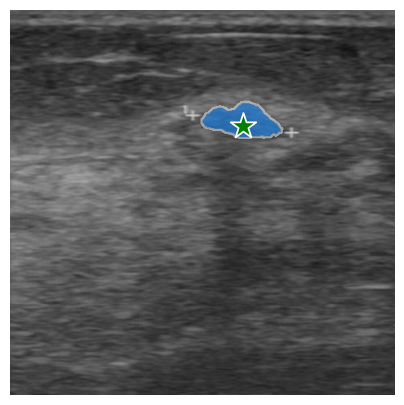

In [16]:
for filename in os.listdir(image_folder):
  if filename.endswith(".png") or filename.endswith(".jpg"):  # only operate image file
    image_path = os.path.join(image_folder, filename)

    '''generate prompt'''
    gt_path = os.path.join(gt_folder, filename)
    gt = Image.open(gt_path)
    gt = np.array(gt.convert("L")) / 255  # convert to 01 img
    median_x, median_y = find_median_point(gt)
    input_point = np.array([[median_y, median_x]])  # note that is (y,x)
    input_label = np.array([1])
    '''generate prompt'''

    pred_mask = segment(1, input_point, image_path, predictor, show_mask=True)  # 1 stands for Single Point Prompt Type

    #I added a break line to run just one single image, delete it to run all images in the folder
    break

SAM2 Single Box

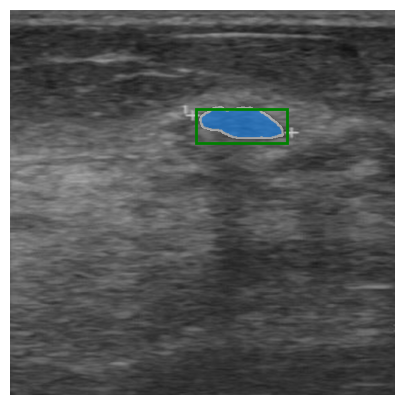

0.8675007108330964


In [19]:
dice_arr = []
for filename in os.listdir(image_folder):
  if filename.endswith(".png") or filename.endswith(".jpg"):  # only operate image file
    image_path = os.path.join(image_folder, filename)

    '''generate prompt'''
    gt_path = os.path.join(gt_folder, filename)
    gt = Image.open(gt_path)
    gt = np.array(gt.convert("L")) / 255  # convert to 01 img
    input_box = find_rect_box(gt)
    '''generate prompt'''

    pred_mask = segment(2, input_box, image_path, predictor, show_mask=True)  # 2 stands for Single Point Prompt Type
    dice = dice_coefficient(pred_mask, gt)
    print(dice)

    #I added a break line to run just one single image, delete it to run all images in the folder
    break